In [2]:
# !pip install xclim 

In [3]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 

from science_validation_manual import *

In [4]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [5]:
client, cluster = rhgk.get_standard_cluster()

In [6]:
cluster

load bias corrected tasmin and bias corrected DTR so that we can compare bias corrected tasmin additively and multiplicatively. The BCC and NCC models didn't complete for DTR, so we're using the GFDL model here - `GDFL-ESM4`. Start with just looking at historical. This will be enough to get a good idea how they compare. 

multiplicatively 

In [7]:
# need bias corrected tasmax and DTR, compute tasmin 
tasmax_hist_bc = read_gcs_zarr('gs://biascorrected-492e989a/stage/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/day/tasmax/gr1/v20211209003119.zarr')
dtr_hist_bc = read_gcs_zarr('gs://biascorrected-492e989a/stage/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/day/dtr/gr1/v20211221191122.zarr')

In [8]:
da_tasmin_lazy = tasmax_hist_bc['tasmax'] - dtr_hist_bc['dtr']
da_tasmin_computed = da_tasmin_lazy.persist()

In [9]:
tasmin_hist_bc_multi = da_tasmin_computed.to_dataset(name='tasmin')

In [27]:
# need bias corrected tasmin 
tasmin_hist_bc_add = read_gcs_zarr('gs://biascorrected-492e989a/stage/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/day/tasmin/gr1/v20220113044908.zarr')

tasmin_cmip6 = read_gcs_zarr('gs://clean-b1dbca25/cmip6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/day/tasmin/gr1/v20190726.zarr')
tasmin_era5 = read_gcs_zarr('gs://scratch-170cd6ec/9b08dceb-c9a2-41ed-8fba-60b0cc90e7f4/e2e-gdfl-esm4-tasmin-wd2xb-1575557848/rechunked.zarr')

In [11]:
tasmin_hist_bc_multi['tasmin']

,Array,Chunk
Bytes,5.73 GiB,513.28 kiB
Shape,"(23725, 180, 360)","(73, 10, 180)"
Count,11700 Tasks,11700 Chunks
Type,float32,numpy.ndarray


In [12]:
tasmin_diff_lazy = tasmin_hist_bc_multi['tasmin'] - tasmin_hist_bc_add['tasmin']

In [13]:
tamsin_diff_computed = tasmin_diff_lazy.persist()

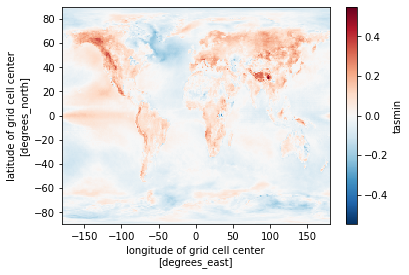

In [14]:
tamsin_diff_computed.mean('time').plot()

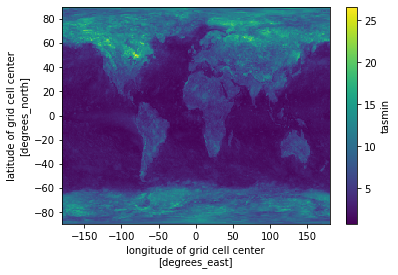

In [15]:
tamsin_diff_computed.max('time').plot()

In [19]:
tasmin_diff_quantiles = tamsin_diff_computed.chunk(dict(time=-1)).quantile([0.05, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99], dim="time")

In [30]:
tasmin_era5_quantiles = tasmin_era5.chunk(dict(time=-1))['tasmin'].quantile([0.05, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99], dim="time").persist()
tasmin_cmip6_quantiles = tasmin_cmip6.chunk(dict(time=-1))['tasmin'].quantile([0.05, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99], dim="time").persist()

In [34]:
tasmin_multi_quantiles = tasmin_hist_bc_multi.chunk(dict(time=-1))['tasmin'].quantile([0.05, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99], dim="time").persist()
tasmin_add_quantiles = tasmin_hist_bc_add.chunk(dict(time=-1))['tasmin'].quantile([0.05, 0.1, 0.5, 0.75, 0.9, 0.95, 0.99], dim="time").persist()

Text(0.5, 1.0, 'maximum')

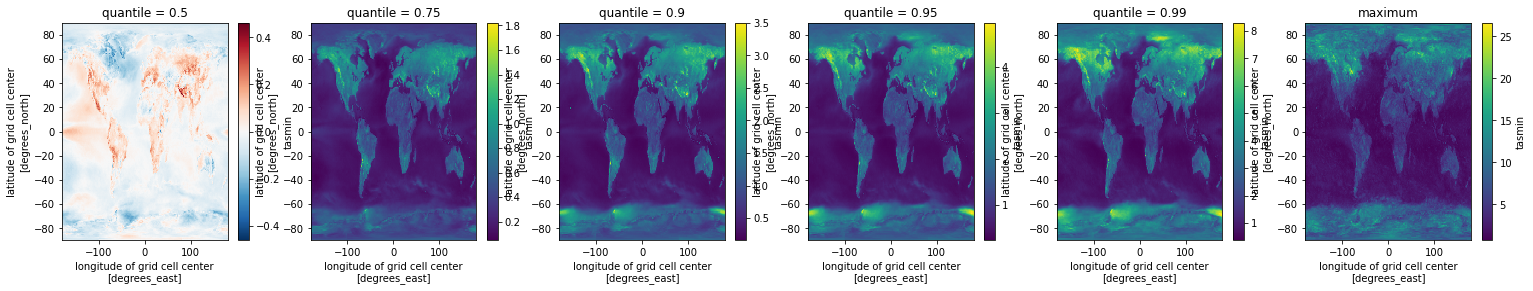

In [21]:
fig, axes = plt.subplots(1, 6, figsize=(26, 4))
tasmin_diff_quantiles.sel(quantile=0.5).plot(ax=axes[0])
tasmin_diff_quantiles.sel(quantile=0.75).plot(ax=axes[1])
tasmin_diff_quantiles.sel(quantile=0.9).plot(ax=axes[2])
tasmin_diff_quantiles.sel(quantile=0.95).plot(ax=axes[3])
tasmin_diff_quantiles.sel(quantile=0.99).plot(ax=axes[4])
tamsin_diff_computed.max('time').plot(ax=axes[5])
axes[5].set_title('maximum')

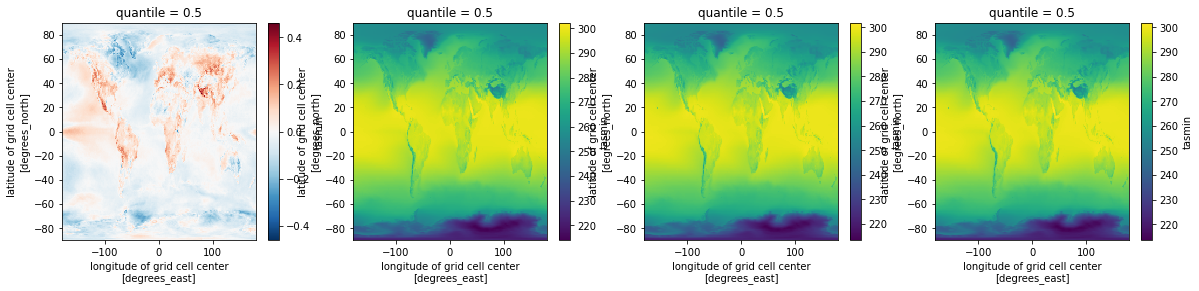

In [39]:
q = 0.5
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
tasmin_diff_quantiles.sel(quantile=q).plot(ax=axes[0])
tasmin_era5_quantiles.sel(quantile=q).plot(ax=axes[1])
tasmin_multi_quantiles.sel(quantile=q).plot(ax=axes[2])
tasmin_add_quantiles.sel(quantile=q).plot(ax=axes[3])

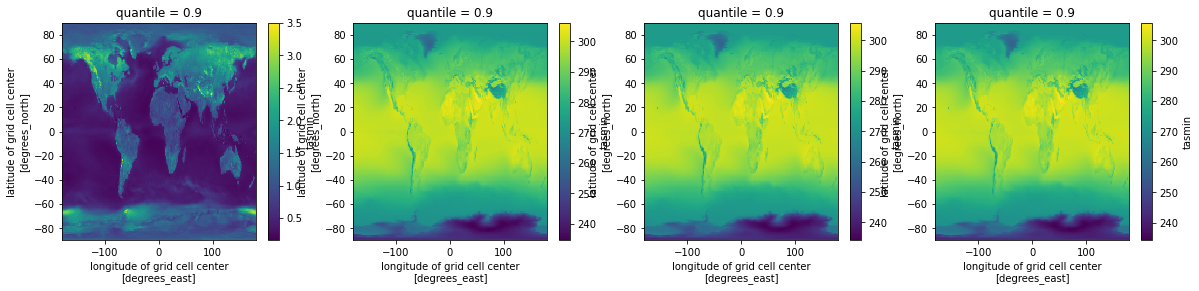

In [40]:
q = 0.9
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
tasmin_diff_quantiles.sel(quantile=q).plot(ax=axes[0])
tasmin_era5_quantiles.sel(quantile=q).plot(ax=axes[1])
tasmin_multi_quantiles.sel(quantile=q).plot(ax=axes[2])
tasmin_add_quantiles.sel(quantile=q).plot(ax=axes[3])

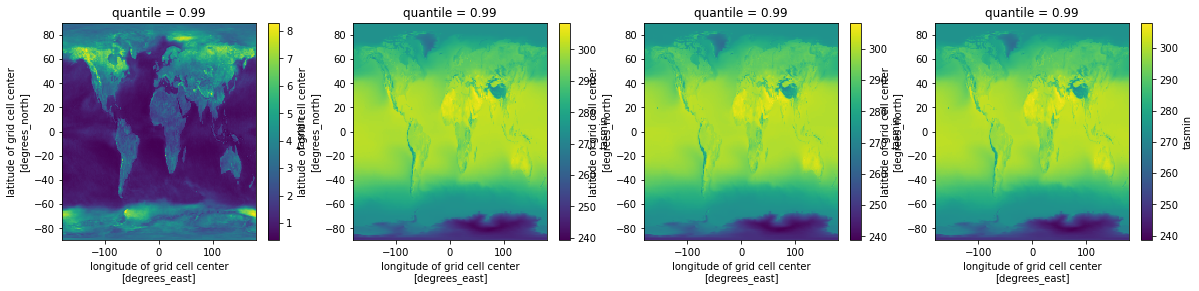

In [42]:
q = 0.99
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
tasmin_diff_quantiles.sel(quantile=q).plot(ax=axes[0])
tasmin_era5_quantiles.sel(quantile=q).plot(ax=axes[1])
tasmin_multi_quantiles.sel(quantile=q).plot(ax=axes[2])
tasmin_add_quantiles.sel(quantile=q).plot(ax=axes[3])

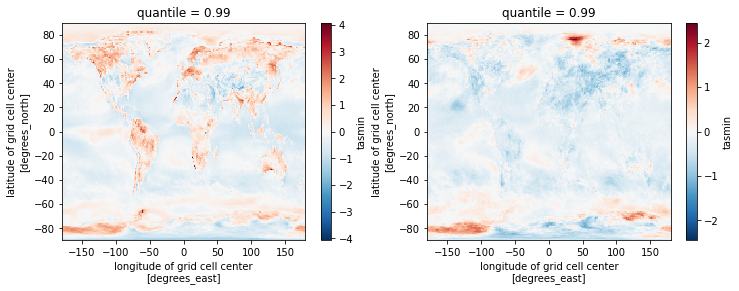

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
(tasmin_multi_quantiles.sel(quantile=q) - tasmin_era5_quantiles.sel(quantile=q)).plot(ax=axes[0])
(tasmin_add_quantiles.sel(quantile=q) - tasmin_era5_quantiles.sel(quantile=q)).plot(ax=axes[1])

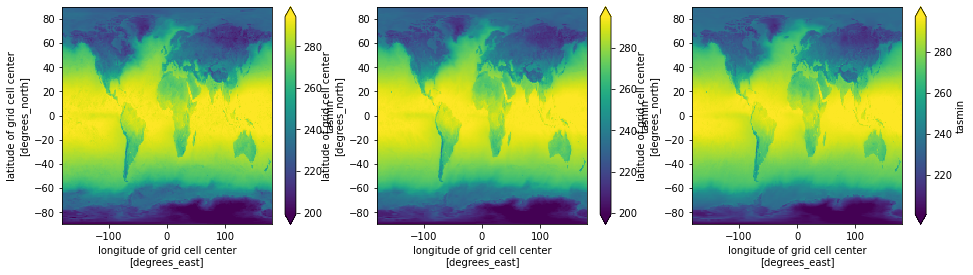

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
tasmin_hist_bc_multi['tasmin'].min('time').plot(ax=axes[0], robust=True)
tasmin_hist_bc_add['tasmin'].min('time').plot(ax=axes[1], robust=True)
tasmin_era5['tasmin'].min('time').plot(ax=axes[2], robust=True)

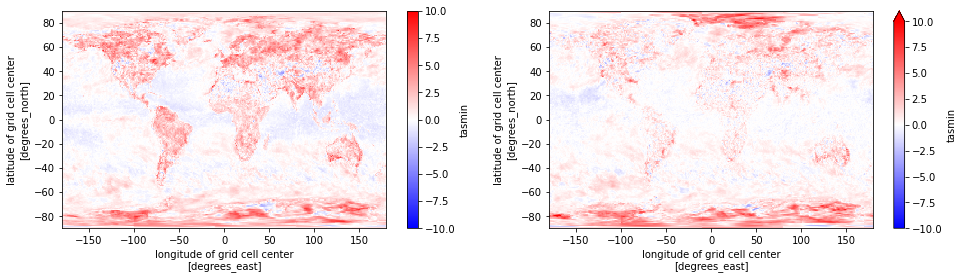

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
(tasmin_hist_bc_multi['tasmin'].max('time') - tasmin_era5['tasmin'].max('time')).plot(ax=axes[0], vmin=-10, vmax=10, cmap='bwr')
(tasmin_hist_bc_add['tasmin'].max('time') - tasmin_era5['tasmin'].max('time')).plot(ax=axes[1], vmin=-10, vmax=10, cmap='bwr')

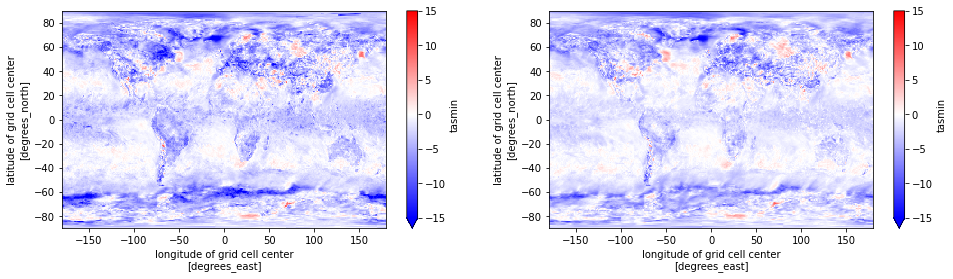

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
(tasmin_hist_bc_multi['tasmin'].min('time') - tasmin_era5['tasmin'].min('time')).plot(ax=axes[0], vmin=-15, vmax=15, cmap='bwr')
(tasmin_hist_bc_add['tasmin'].min('time') - tasmin_era5['tasmin'].min('time')).plot(ax=axes[1], vmin=-15, vmax=15, cmap='bwr')

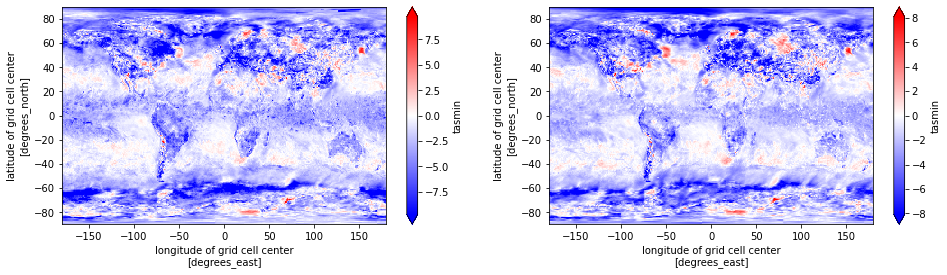

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
(tasmin_hist_bc_multi['tasmin'].min('time') - tasmin_era5['tasmin'].min('time')).plot(ax=axes[0], robust=True, cmap='bwr')
(tasmin_hist_bc_add['tasmin'].min('time') - tasmin_era5['tasmin'].min('time')).plot(ax=axes[1], robust=True, cmap='bwr')

In [62]:
tasmin_season_multi = tasmin_hist_bc_multi['tasmin'].groupby('time.season').mean('time')
tasmin_season_add = tasmin_hist_bc_add['tasmin'].groupby('time.season').mean('time')
tasmin_season_era5 = tasmin_era5['tasmin'].groupby('time.season').mean('time')

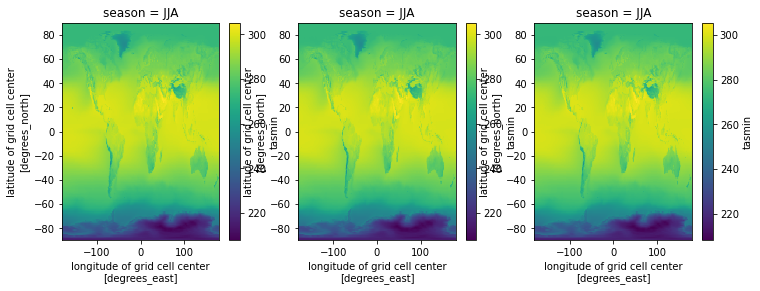

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
season = 'JJA'
tasmin_season_multi.sel(season=season).plot(ax=axes[0])
tasmin_season_add.sel(season=season).plot(ax=axes[1])
tasmin_season_era5.sel(season=season).plot(ax=axes[2])

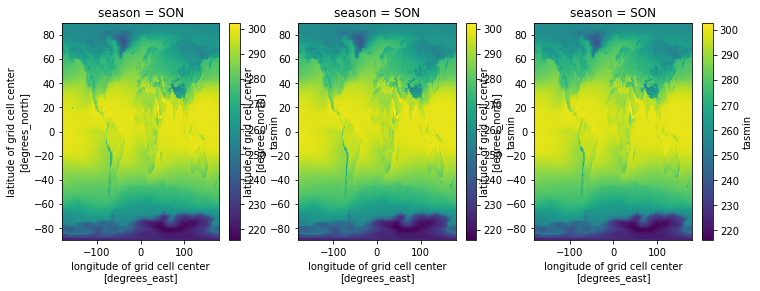

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
season = 'SON'
tasmin_season_multi.sel(season=season).plot(ax=axes[0])
tasmin_season_add.sel(season=season).plot(ax=axes[1])
tasmin_season_era5.sel(season=season).plot(ax=axes[2])

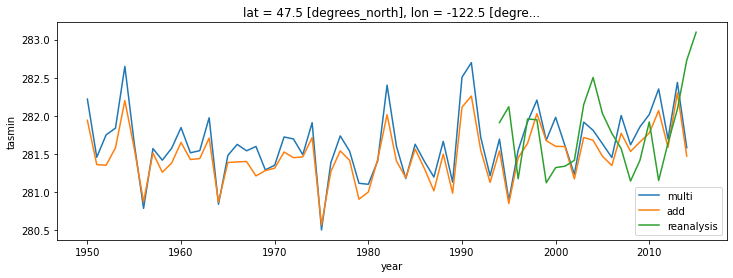

In [69]:
plt.figure(figsize=(12, 4))
target_lat = 47.608013
target_lon = -122.335167

tasmin_hist_bc_multi['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").groupby('time.year').mean().load().plot(label='multi')
tasmin_hist_bc_add['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").groupby('time.year').mean().load().plot(label='add')
tasmin_era5['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").groupby('time.year').mean().load().plot(label='reanalysis')
plt.legend()

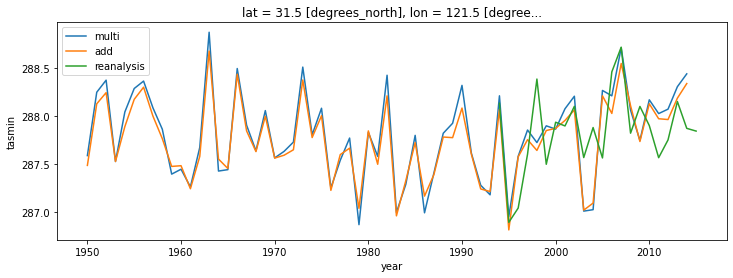

In [72]:
plt.figure(figsize=(12, 4))
target_lat = 31.23
target_lon = 121.47

tasmin_hist_bc_multi['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").groupby('time.year').mean().load().plot(label='multi')
tasmin_hist_bc_add['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").groupby('time.year').mean().load().plot(label='add')
tasmin_era5['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").groupby('time.year').mean().load().plot(label='reanalysis')
plt.legend()

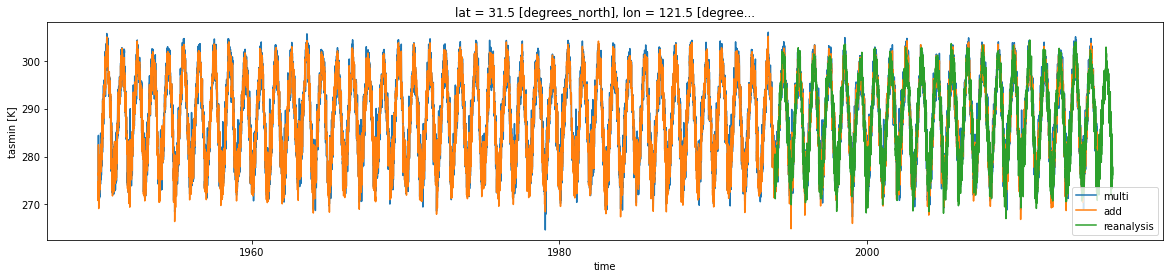

In [74]:
plt.figure(figsize=(20, 4))
target_lat = 31.23
target_lon = 121.47

tasmin_hist_bc_multi['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").load().plot(label='multi')
tasmin_hist_bc_add['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").load().plot(label='add')
tasmin_era5['tasmin'].sel(lon=target_lon, lat=target_lat, method="nearest").load().plot(label='reanalysis')
plt.legend()

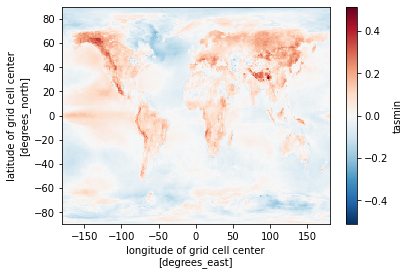

In [16]:
tamsin_diff_computed.sel(time=slice("1994", "2014")).mean('time').plot()